# PART I - DATA PREPROCESSING

In [157]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import keras
from scipy import ndimage
from keras.layers import Input, Lambda
import keras.backend as K
from keras.models import Model
from keras.datasets import mnist
import random
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd


tf.random.set_seed(seed=0)
random.seed(0)
np.random.seed(0)
keras.utils.set_random_seed(0)

from resnet import ResNet18
# load dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

# change the shape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# prepare the test data
y_test_encoded = to_categorical(Y_test)
x_test = X_test

# set the colormap.
plt.rc("image",cmap="gray")

(28, 28, 1)

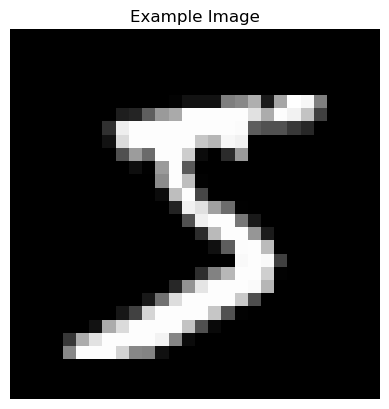

In [158]:
# example image
plt.imshow(tf.squeeze(X_train[0]))
plt.axis("off")
plt.title("Example Image")

# get the input shape
data_input_shape = X_train[0].shape
data_input_shape

# PART II - RESNET18 ON MNIST DATA

### Training

In [159]:
# create train and validation splits
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=3)
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

earlystop = keras.callbacks.EarlyStopping(
    min_delta=0.01,
    restore_best_weights=True,
    patience=3,
)

In [160]:
print(f"x_train shape: {x_train.shape}\nx_val shape: {x_val.shape}\ny_train shape: {y_train_encoded.shape}\ny_val shape: {y_val_encoded.shape}")

x_train shape: (48000, 28, 28, 1)
x_val shape: (12000, 28, 28, 1)
y_train shape: (48000, 10)
y_val shape: (12000, 10)


In [161]:
# build the resnet18 model
resnet_18 = ResNet18()
resnet_18(tf.zeros([1, 28,28,1]), training = True)
resnet_18.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
resnet_18.summary()

Model: "res_net18_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_conv2d_400 (MyConv2D)        │ ?                      │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_160              │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_161              │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_162              │ ?                      │       231,296 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_163              │ ?                      │       296,192 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_164              │ ?                      │       921,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_165              │ ?                      │     1,182,208 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_166              │ ?                      │     3,677,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_167              │ ?                      │     4,723,712 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,770 (42.69 MB)

 Trainable params: 11,180,170 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [162]:
# train the model
history = resnet_18.fit(x_train, y_train_encoded, batch_size=2048, epochs=5, validation_data=(x_val, y_val_encoded), callbacks=[earlystop])

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.7451 - loss: 1.0714 - val_accuracy: 0.3665 - val_loss: 25.9247
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.9767 - loss: 0.0744 - val_accuracy: 0.4597 - val_loss: 5.6000
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.9877 - loss: 0.0401 - val_accuracy: 0.6988 - val_loss: 1.5063
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.9931 - loss: 0.0245 - val_accuracy: 0.8691 - val_loss: 0.4670
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.9945 - loss: 0.0181 - val_accuracy: 0.9311 - val_loss: 0.2245


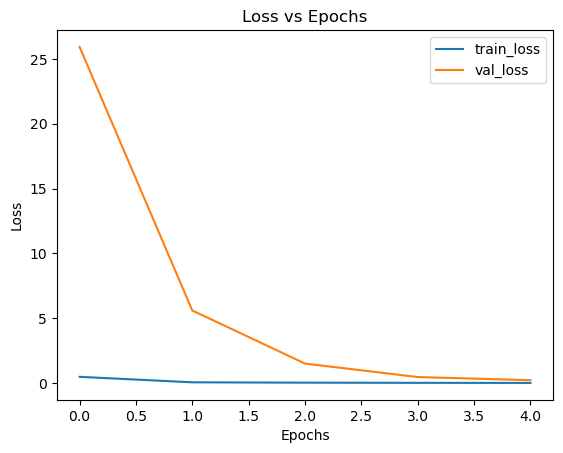

In [163]:
# plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


### Test the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


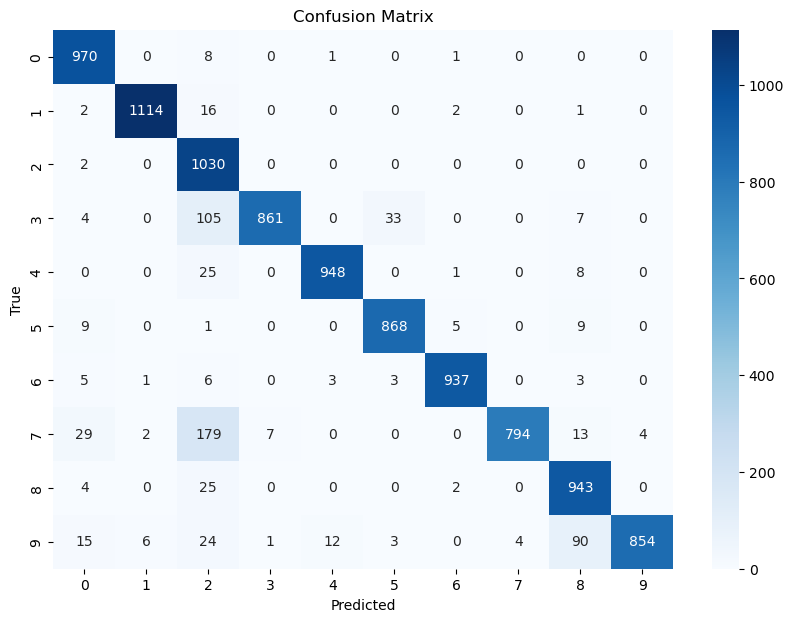

In [164]:
# plot the confusion matrix
y_pred = resnet_18.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = Y_test.astype("int")
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [165]:
# print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9319


# PART III - RESNET18 WITH FEW SHOT LEARNING ON 6% OF MNIST

### Functions

In [166]:


def triplet_loss(margin=1.0):
    """
    A function that returns the triplet loss function.
    """
    def _triplet_loss(_, y_pred):
        
        # get the anchor, positive and negative embeddings
        anchor, positive, negative = y_pred[:,0], y_pred[:,1], y_pred[:,2]
        # calculate the distance between the anchor and the positive
        positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        
        # calculate triplet loss
        loss = tf.maximum(positive_distance - negative_distance + margin, 0.0)

        return tf.reduce_mean(loss)
    return _triplet_loss

def get_triplets(x, y, n_classes, n_samples):
    np.random.seed(0)
    triplets = []
    # create an array of labels
    labels = np.arange(n_classes)
    for label in labels:
        # get the indices of images belongs the current class
        class_indices = np.where(y == label)[0]

        # get the indices of images belongs to other classes
        other_indices = np.where(y != label)[0]

        for i in range(n_samples):
            # Select an anchor from the current class
            anchor_index = class_indices[i% len(class_indices)]

            # Select a positive sample from the current class
            positive_index = class_indices[(i+1) % len(class_indices)]

            # Select a negative sample from the other classes
            negative_index = np.random.choice(other_indices)

            # Append the triplet to the triplets list
            triplets.append([x[anchor_index], x[positive_index], x[negative_index]])

    return np.array(triplets)

# get the support set
def get_random_support(model,x, y ,n ,k):
    """
    A function that creates random support set for each class. It returns the normalized mean feature of the support set.
    """
    np.random.seed(0)
    
    support_set = []
    for i in range(n):
        # get the indices of images belongs the current class
        class_indices = np.where(y == i)[0]

        # select k random samples from the current class
        support_indices = np.random.choice(class_indices, k, replace=False)
        
        # append the support set
        feature = model.predict([x[support_indices], x[support_indices], x[support_indices]])[0]
        
        mean_feature = tf.reduce_mean(feature, axis=0)
        mean_feature = mean_feature / tf.norm(mean_feature)
        
        support_set.append(mean_feature)
        
    return np.array(support_set)

def make_prediction(support_set, query):
    """
    A function that makes predictions based on the distance between support sets and query.
    
    """
    predictions = []
    for feature in query:
        # Calculate the Euclidean distance to each support set vector
        distances = np.linalg.norm(support_set - feature, axis=1)
        # Find the support set vector with the minimum distance
        prediction = np.argmin(distances)
        predictions.append(prediction)

    return np.array(predictions)

### Training

In [167]:
from resnet_fsl import ResNet18_fsl

base_model = ResNet18_fsl()

input_shape = (28, 28, 1)

# define inputs for triplet loss function
anchor_input = Input(input_shape, name="anchor_input")
positive_input = Input(input_shape, name="positive_input")
negative_input = Input(input_shape, name="negative_input")

# process each input through the same base network (ResNet18)
encoded_anchor = base_model(anchor_input)
encoded_positive = base_model(positive_input)
encoded_negative = base_model(negative_input)

out = Lambda(lambda x: tf.stack(x, axis=1),output_shape=(3,512))([encoded_anchor, encoded_positive, encoded_negative])

# define the triplet network
triplet_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=out)

triplet_network.compile(optimizer="adam", loss=triplet_loss(margin=1.0))

triplet_network.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net18_fsl_12    │ (None, 512)       │ 11,184,640 │ anchor_input[0][… │
│ (ResNet18_fsl)      │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 3, 512)    │          0 │ res_net18_fsl_12… │
│                     │                   │            │ res_net18_fsl_12… │
│                     │                   │            │ res_net18_fsl_12… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,184,640 (42.67 MB)

 Trainable params: 11,175,040 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [168]:
n_classes = 10
n_samples = 100 # number of samples per class

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.01)

# get the triplets
triplet_pairs = get_triplets(x_train, x_train, n_classes, n_samples)
y_dummy = np.zeros((len(triplet_pairs)))

anchors = triplet_pairs[:, 0]
positives = triplet_pairs[:, 1]
negatives = triplet_pairs[:, 2]

# train the triplet network
history = triplet_network.fit([anchors, positives, negatives], y_dummy, batch_size=16, epochs=20, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 84.5093 - val_loss: 895.8390
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 60.9342 - val_loss: 202.6612
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 16.8516 - val_loss: 17.8878
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 2.2167 - val_loss: 15.5029
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 1.5689 - val_loss: 13.0539
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.4286 - val_loss: 17.5033
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.6371 - val_loss: 13.2983
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.5434 - val_loss: 15.8792
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 1.4275 - val_loss: 30.0456
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 4.2044 - val_loss: 22.0269


In [169]:
n = 10 
k = 10 # support vector size

support_set = get_random_support(triplet_network,x_train, y_train, n, k)
print(support_set.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(10, 512)


In [170]:
# query image
query_image = x_test[0:500]

# get the feature of the query image
feature = triplet_network.predict([query_image, query_image,query_image])
anchor_features = feature[:,0,:]

normalized_features = anchor_features / np.linalg.norm(anchor_features, axis=1, keepdims=True)

predictions = make_prediction(support_set, normalized_features)
predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


array([4, 2, 1, 0, 7, 1, 7, 8, 3, 7, 0, 8, 7, 0, 1, 3, 9, 2, 3, 7, 7, 8,
       9, 8, 7, 2, 3, 7, 0, 1, 3, 1, 3, 4, 4, 2, 9, 9, 6, 1, 1, 9, 7, 9,
       8, 8, 1, 6, 7, 7, 8, 3, 5, 3, 2, 0, 7, 1, 7, 1, 3, 9, 6, 9, 9, 7,
       9, 7, 3, 2, 2, 2, 2, 9, 1, 7, 8, 2, 7, 9, 9, 8, 2, 9, 9, 7, 9, 3,
       8, 1, 9, 8, 4, 9, 1, 7, 1, 7, 0, 7, 6, 0, 5, 7, 3, 7, 2, 6, 9, 7,
       8, 6, 6, 9, 9, 7, 7, 7, 7, 2, 9, 8, 3, 8, 7, 8, 2, 9, 9, 9, 8, 8,
       9, 9, 8, 1, 0, 1, 8, 4, 6, 9, 3, 1, 7, 1, 8, 3, 0, 8, 9, 3, 7, 8,
       1, 5, 8, 0, 2, 9, 7, 0, 5, 7, 9, 3, 9, 5, 1, 7, 7, 8, 2, 2, 2, 1,
       1, 5, 1, 8, 1, 8, 8, 2, 5, 9, 2, 9, 0, 1, 1, 1, 0, 3, 0, 3, 1, 8,
       7, 8, 3, 2, 1, 1, 1, 9, 7, 2, 3, 7, 7, 4, 9, 8, 7, 2, 5, 8, 4, 5,
       9, 2, 3, 8, 1, 2, 9, 9, 1, 1, 8, 6, 8, 9, 9, 9, 2, 8, 7, 1, 8, 9,
       9, 7, 6, 9, 2, 5, 7, 6, 7, 1, 7, 6, 3, 2, 0, 8, 2, 2, 8, 9, 9, 9,
       8, 1, 8, 1, 3, 3, 3, 0, 1, 7, 9, 7, 1, 9, 2, 1, 0, 7, 8, 1, 9, 2,
       8, 3, 1, 6, 5, 2, 3, 2, 0, 7, 2, 2, 2, 8, 7,

In [171]:
anchor_features.shape, normalized_features.shape

((500, 512), (500, 512))

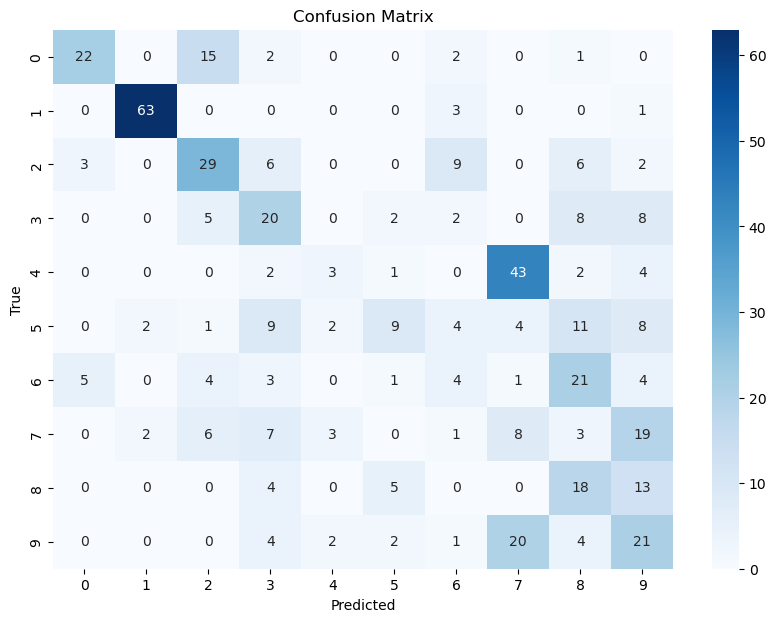

In [172]:
# create a confusion matrix
cm = confusion_matrix(y_test[:500], predictions)
cm = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [173]:
# print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test[:500], predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.394


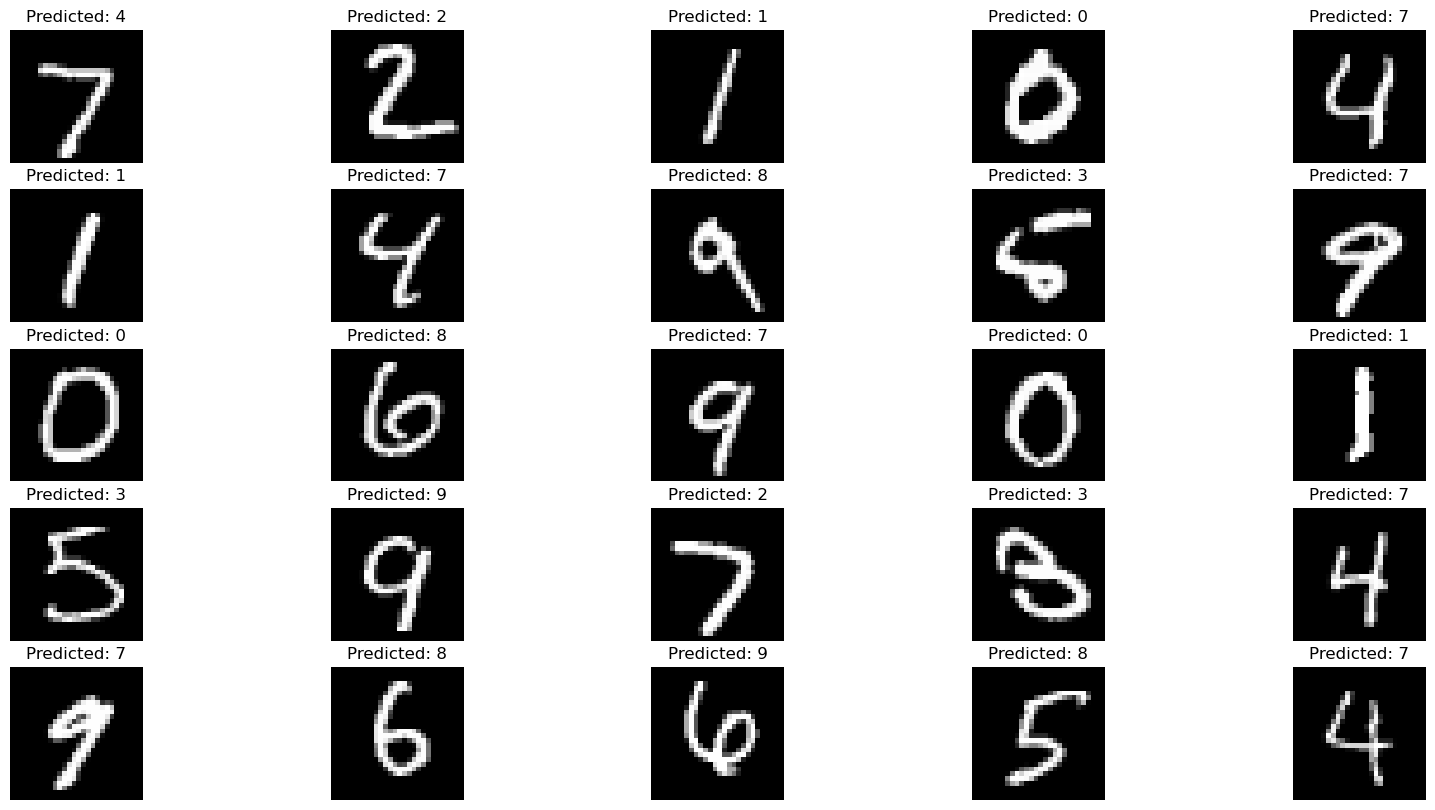

In [174]:
# print the 5 elements of x test
plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(tf.squeeze(x_test[i]))
    plt.title(f"Predicted: {predictions[i]}")
    plt.axis("off")
plt.show()

# PART IV - AUGMENTING CUSTOM IMAGES

In [201]:
# get all the image file names
image_files = [f for f in os.listdir('./digits_im') if f.endswith(('.JPG', '.jpeg', '.png', '.jpg'))]
print(len(image_files))
# Reading images
images = []
labels = []
for file in image_files:
    img = cv2.imread(f"./digits_im/{file}", cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    # img = img / 255.0
    labels.append(int(file.split("_")[0]))
    if img is not None:
        images.append(img)
    else:
        print(f"Warning: {file} could not be read.")



26


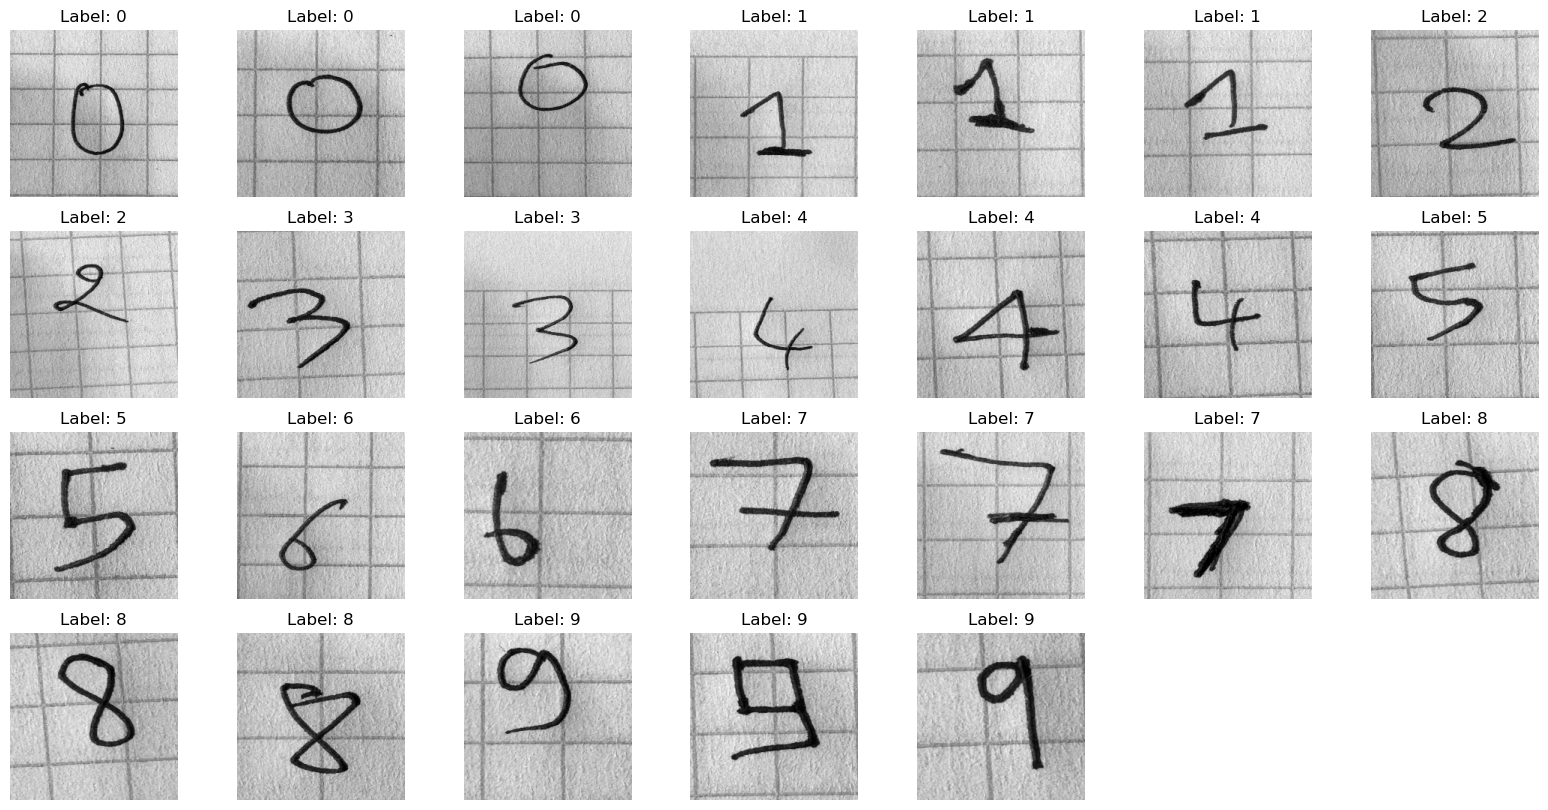

In [202]:
# print the images
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(4, 7, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()


### Data Augmentation

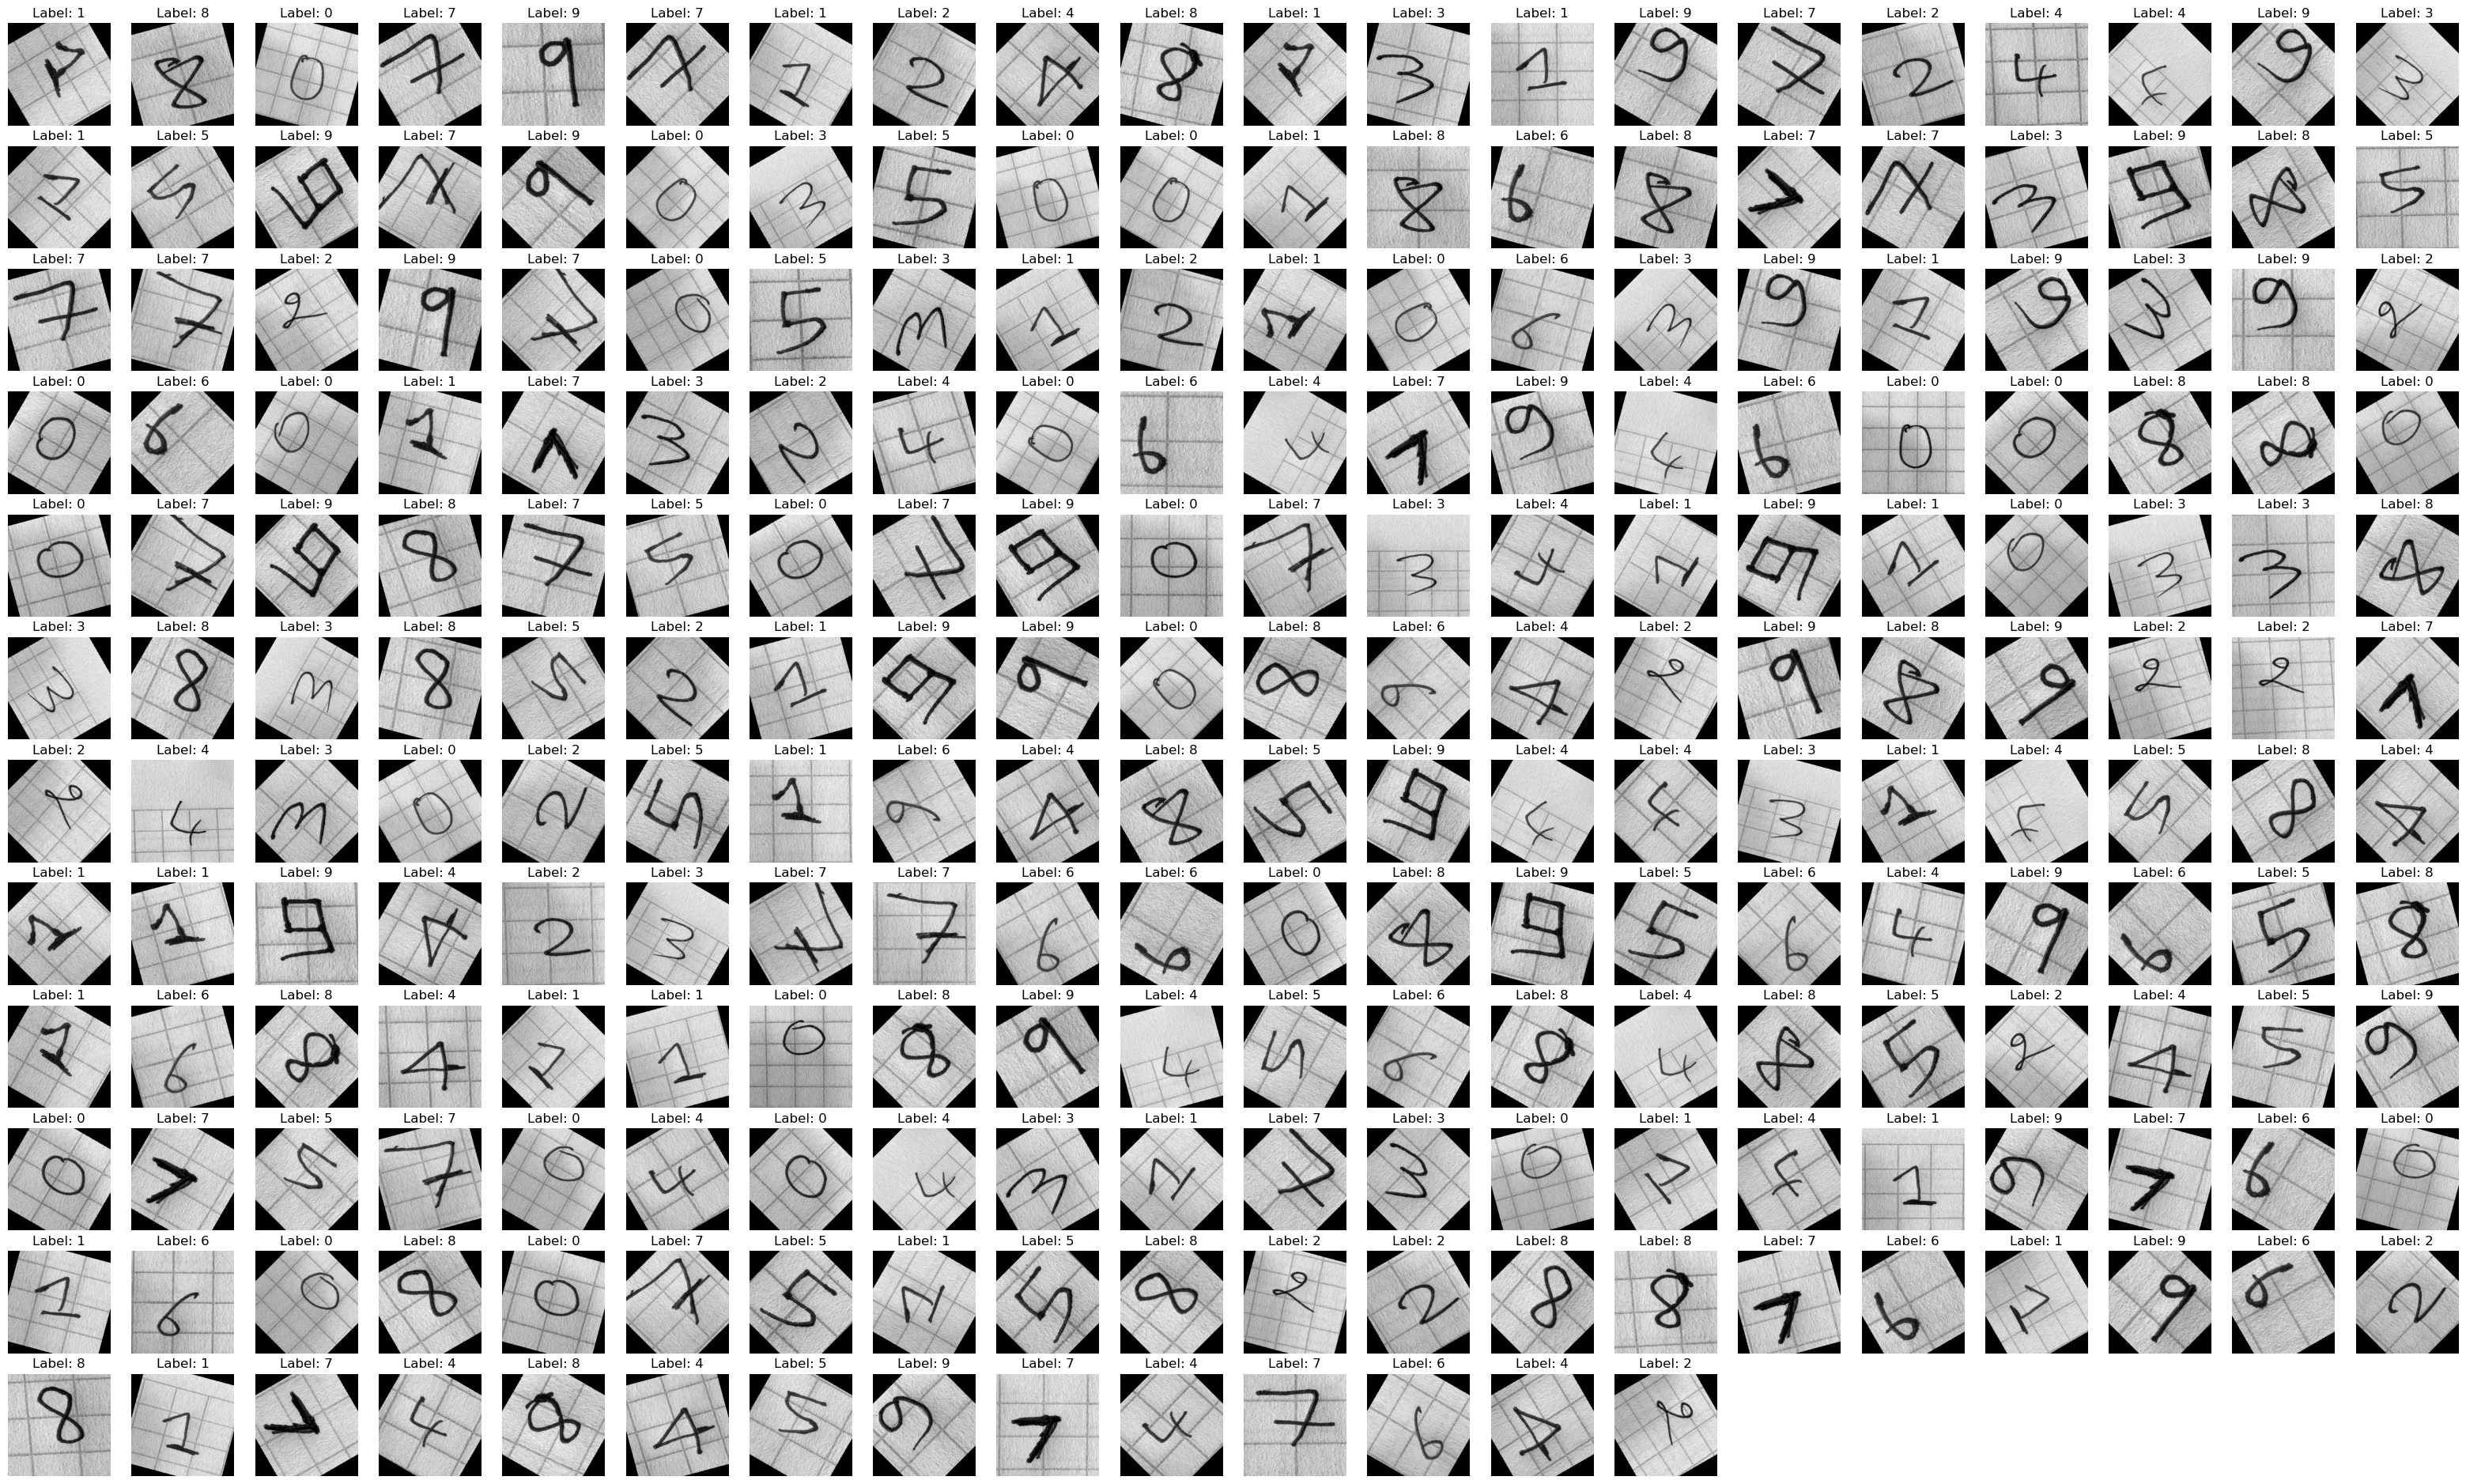

In [203]:
np.random.seed(0)

def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for i in range(len(images)):
        augmented_images.append(images[i])
        augmented_labels.append(labels[i])
        # # horizontal flip
        # if labels[i] not in [2,5]:
        #     augmented_images.append(cv2.flip(images[i], 1))
        #     augmented_labels.append(labels[i])
        # # vertical flip
        # if labels[i] not in [5,2,6,9, 4]:
        #     augmented_images.append(cv2.flip(images[i], 0))
        #     augmented_labels.append(labels[i])
        # rotation 15 degrees
        augmented_images.append(ndimage.rotate(images[i], 15, reshape=False))
        augmented_labels.append(labels[i])
        augmented_images.append(ndimage.rotate(images[i], -15, reshape=False))
        augmented_labels.append(labels[i])
        # rotation 30 degrees
        augmented_images.append(ndimage.rotate(images[i], 30, reshape=False))
        augmented_labels.append(labels[i])
        augmented_images.append(ndimage.rotate(images[i], -30, reshape=False))
        augmented_labels.append(labels[i])
        # rotation 45 degrees
        augmented_images.append(ndimage.rotate(images[i], 45, reshape=False))
        augmented_labels.append(labels[i])
        augmented_images.append(ndimage.rotate(images[i], -45, reshape=False))
        augmented_labels.append(labels[i])
        # rotation 60 degrees
        augmented_images.append(ndimage.rotate(images[i], 60, reshape=False))
        augmented_labels.append(labels[i])
        augmented_images.append(ndimage.rotate(images[i], -60, reshape=False))
        augmented_labels.append(labels[i])
    return np.array(augmented_images), np.array(augmented_labels)

augmented_images, augmented_labels = augment_data(images, labels)

# shuffle the data
indices = np.arange(len(augmented_labels))
np.random.shuffle(indices)
augmented_images = augmented_images[indices]
augmented_labels = augmented_labels[indices]

# print the augmented images
plt.figure(figsize=(40, 40))
for i in range(len(augmented_images)):
    plt.subplot(20, 20, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f"Label: {augmented_labels[i]}")
    plt.axis("off")
plt.show()

# PART V - RESNET18 ON AUGMENTED CUSTOM DATA

In [204]:
# split the data
augmented_images_for_train = augmented_images.copy()
augmented_images_for_train = augmented_images_for_train.astype('float32')
augmented_images_for_train = augmented_images_for_train.reshape(-1, 224, 224, 1)
x_train, x_test, y_train, y_test = train_test_split(augmented_images_for_train, augmented_labels, test_size = 0.2, random_state=3)
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


# first train the resnet18 model

resnet_18 = ResNet18()
resnet_18(tf.zeros([1, 224, 224, 1]), training = True)
resnet_18.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
resnet_18.summary()

Model: "res_net18_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_conv2d_520 (MyConv2D)        │ ?                      │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_208              │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_209              │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_210              │ ?                      │       231,296 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_211              │ ?                      │       296,192 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_212              │ ?                      │       921,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_213              │ ?                      │     1,182,208 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_214              │ ?                      │     3,677,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_215              │ ?                      │     4,723,712 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_26     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,770 (42.69 MB)

 Trainable params: 11,180,170 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.1383 - loss: 4.5302 - val_accuracy: 0.1316 - val_loss: 53492.1680
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.3098 - loss: 2.0554 - val_accuracy: 0.1316 - val_loss: 1894.9307
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.4476 - loss: 1.4358 - val_accuracy: 0.1316 - val_loss: 80.3944
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.5496 - loss: 1.1725 - val_accuracy: 0.1316 - val_loss: 64.6164
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.6728 - loss: 0.9141 - val_accuracy: 0.1316 - val_loss: 26.6636
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.6887 - loss: 0.7490 - val_accuracy: 0.1316 - val_loss: 28.1856
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.6502 - loss: 0.8875 - val_accuracy: 0.1316 - val_loss: 76.1067
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.7370 - loss: 0.7842 - val

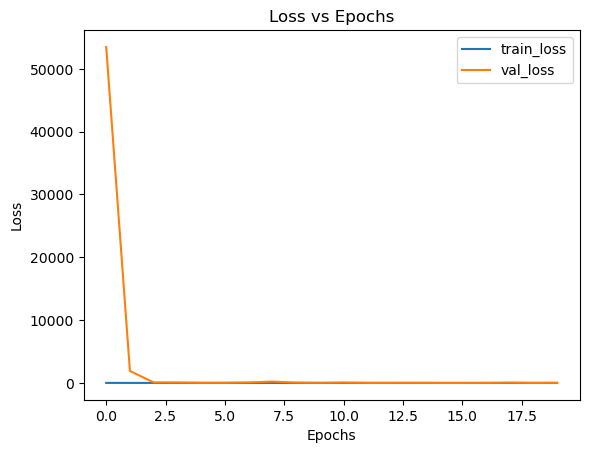

In [205]:
history = resnet_18.fit(x_train, y_train_encoded, batch_size=4, epochs=20, validation_split=0.2)

# plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


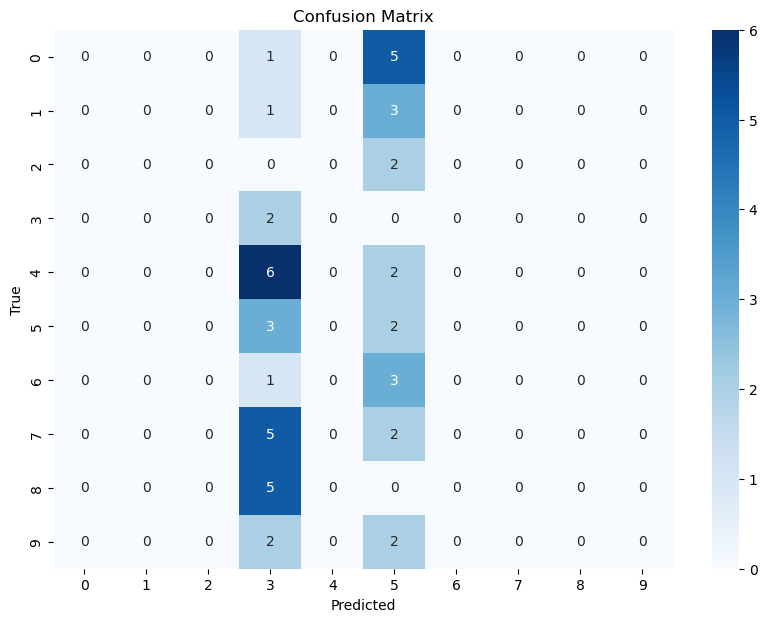

In [206]:
# plot the confusion matrix
y_pred = resnet_18.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = y_test.astype("int")
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [207]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.0851063829787234


# PART VI - RESNET18 WITH FSL ON AUGMENTED CUSTOM DATA

### Training

In [208]:
base_model = ResNet18_fsl()

input_shape = (224, 224, 1)

# define inputs for triplet loss function

anchor_input = Input(input_shape, name="anchor_input")
positive_input = Input(input_shape, name="positive_input")
negative_input = Input(input_shape, name="negative_input")


# Process each input through the same base network (ResNet18)

encoded_anchor = base_model(anchor_input)
encoded_positive = base_model(positive_input)
encoded_negative = base_model(negative_input)

out = Lambda(lambda x: tf.stack(x, axis=1),output_shape=(3,512))([encoded_anchor, encoded_positive, encoded_negative])

# define the triplet network

triplet_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=out)

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# triplet_network.compile(optimizer=optimizer, loss=triplet_loss(margin=1.0))

triplet_network.compile(optimizer="adam", loss=triplet_loss(margin=1.0))

triplet_network.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net18_fsl_15    │ (None, 512)       │ 11,184,640 │ anchor_input[0][… │
│ (ResNet18_fsl)      │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 3, 512)    │          0 │ res_net18_fsl_15… │
│                     │                   │            │ res_net18_fsl_15… │
│                     │                   │            │ res_net18_fsl_15… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,184,640 (42.67 MB)

 Trainable params: 11,175,040 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [209]:
n_classes = 10
n_samples = 20 # number of samples per class

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.01)

# get the triplets
triplet_pairs = get_triplets(x_train, x_train, n_classes, n_samples)
y_dummy = np.zeros((len(triplet_pairs)))

anchors = triplet_pairs[:, 0]
positives = triplet_pairs[:, 1]
negatives = triplet_pairs[:, 2]

# train the triplet network
history = triplet_network.fit([anchors, positives, negatives], y_dummy, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 5.0367 - val_loss: 164958.5938
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 4.6959 - val_loss: 12883.6484
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.2936 - val_loss: 464.6108
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.1280 - val_loss: 26.3629
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0000e+00 - val_loss: 1.6006
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0019 - val_loss: 0.0000e+00
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [210]:
n = 10 
k = 3 # support vector size

support_set = get_random_support(triplet_network,x_train, y_train, n, k)

# query image
query_image = x_test

# get the feature of the query image
feature = triplet_network.predict([query_image, query_image,query_image])
anchor_features = feature[:,0,:]

normalized_features = anchor_features / np.linalg.norm(anchor_features, axis=1, keepdims=True)

predictions = make_prediction(support_set, normalized_features)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step


array([8, 2, 3, 2, 7, 7, 6, 6, 6, 8, 7, 6, 4, 4, 0, 7, 2, 6, 7, 3, 4, 6,
       2, 2, 5, 4, 5, 2, 8, 4, 6, 0, 9, 5, 6, 4, 8, 4, 3, 5, 7, 6, 2, 3,
       1, 6, 6])

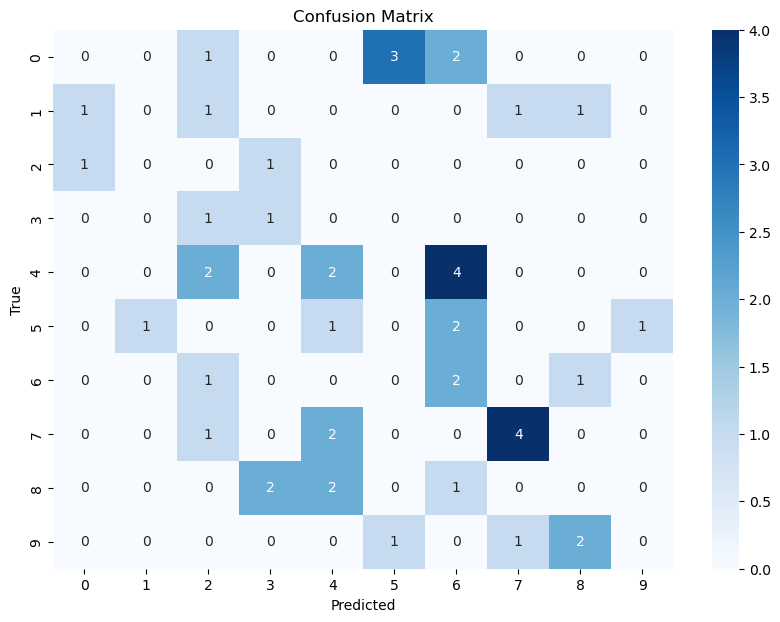

In [211]:
# create a confusion matrix
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [212]:
# print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.19148936170212766


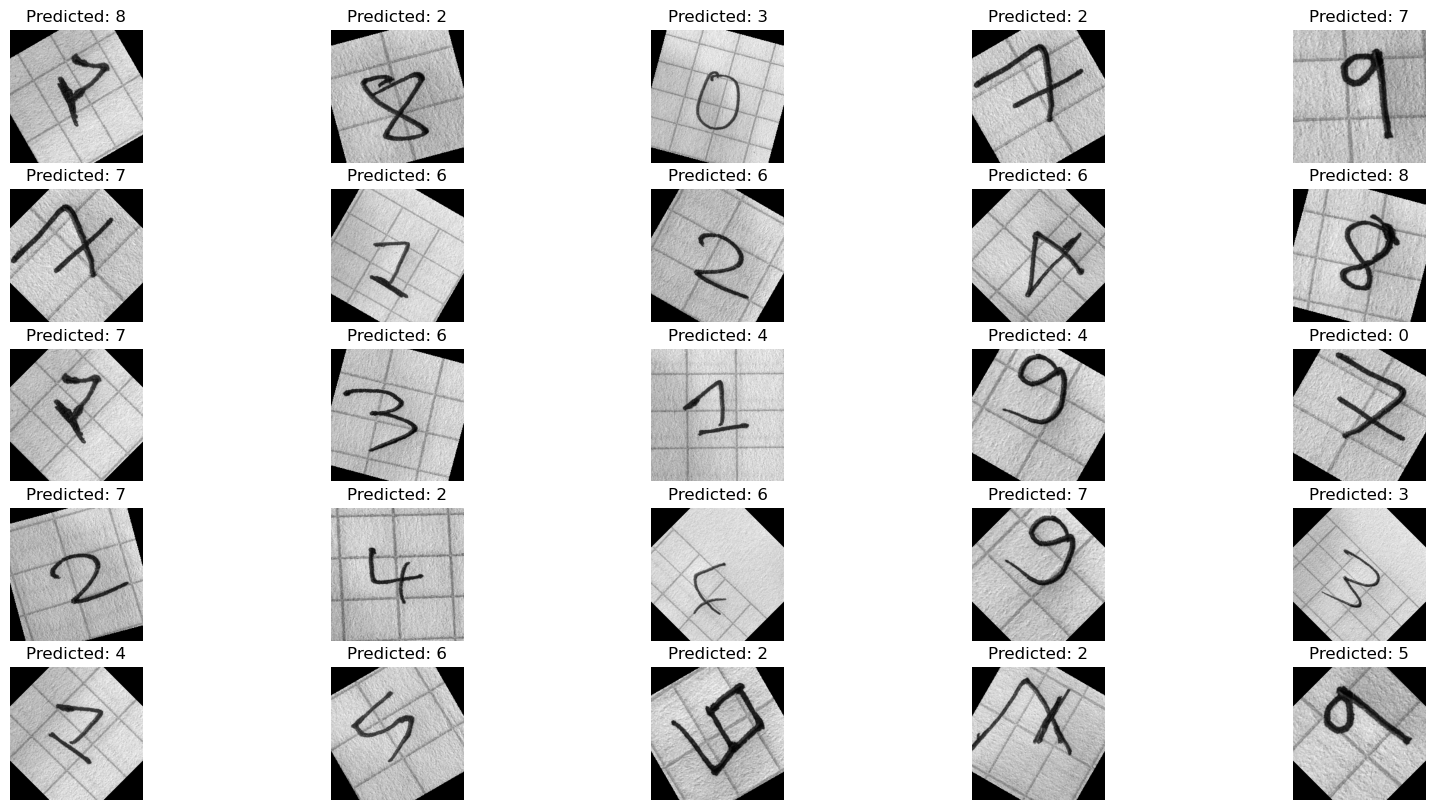

In [213]:
plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f"Predicted: {predictions[i]}")
    plt.axis("off")
plt.show()